## Homework 1 - Time Series Analysis - EDS 296

**Marina Kochuten - Spring 2025**

Plotting historic and projected surface air temperature from 1850-2100 in the Aleutian Island Archipelago

### Locate monthly data for a historical simulation run

In [1]:
# Import packages
import xarray as xr
import matplotlib.pyplot as plt
import intake
import s3fs
import numpy as np
import cftime
from scipy.stats import linregress

In [2]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

# Search through catalog, find all historical simulations
# ("activity_id=CMIP", "experiment_id=historical")
res = catalog.search(activity_id="CMIP", experiment_id="historical")

# Convert to a data frame
res_df = res.df

# Get unique model names in the set of search results
models = res_df.source_id.unique()

# Print list of model names
print(models)

['GFDL-CM4' 'GFDL-ESM4' 'IPSL-CM6A-LR' 'GISS-E2-1-G' 'CNRM-CM6-1'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CNRM-ESM2-1' 'MIROC6' 'AWI-CM-1-1-MR'
 'MRI-ESM2-0' 'CESM2-WACCM' 'CanESM5' 'CESM2' 'SAM0-UNICON' 'GISS-E2-1-H'
 'UKESM1-0-LL' 'EC-Earth3' 'CanESM5-CanOE' 'INM-CM4-8' 'EC-Earth3-Veg'
 'INM-CM5-0' 'HadGEM3-GC31-LL' 'MPI-ESM-1-2-HAM' 'NESM3' 'CAMS-CSM1-0'
 'MPI-ESM1-2-LR' 'MPI-ESM1-2-HR' 'E3SM-1-0' 'MCM-UA-1-0' 'NorESM2-LM'
 'GISS-E2-1-G-CC' 'FGOALS-g3' 'FGOALS-f3-L' 'MIROC-ES2L' 'KACE-1-0-G'
 'NorCPM1' 'CNRM-CM6-1-HR' 'KIOST-ESM' 'NorESM2-MM' 'ACCESS-CM2'
 'FIO-ESM-2-0' 'ACCESS-ESM1-5' 'CESM2-FV2' 'CESM2-WACCM-FV2' 'GISS-E2-2-H'
 'E3SM-1-1' 'HadGEM3-GC31-MM' 'IITM-ESM' 'CIESM' 'E3SM-1-1-ECA'
 'AWI-ESM-1-1-LR' 'EC-Earth3-Veg-LR' 'TaiESM1' 'CAS-ESM2-0' 'CMCC-CM2-SR5'
 'EC-Earth3-AerChem' 'IPSL-CM5A2-INCA' 'CMCC-CM2-HR4' 'EC-Earth3P-VHR'
 'EC-Earth3-CC' 'CMCC-ESM2' 'MIROC-ES2H' 'ICON-ESM-LR' 'IPSL-CM6A-LR-INCA']


In [3]:
# Search through catalog, find all historical simulations with CMCC-ESM2 and CanESM5
res = catalog.search(activity_id="CMIP", experiment_id="historical", source_id="CMCC-ESM2")
res2 = catalog.search(activity_id="CMIP", experiment_id="historical", source_id="CanESM5")

# Convert to a data frame
res_df = res.df
res2_df = res2.df

# Print all unique ensemble members ("member_id")
members = res_df.member_id.unique()
members2 = res2_df.member_id.unique()

print(members)
print(members2)

['r1i1p1f1']
['r24i1p1f1' 'r25i1p1f1' 'r14i1p1f1' 'r2i1p1f1' 'r17i1p1f1' 'r10i1p1f1'
 'r13i1p1f1' 'r7i1p1f1' 'r6i1p1f1' 'r5i1p1f1' 'r3i1p1f1' 'r22i1p1f1'
 'r23i1p1f1' 'r8i1p1f1' 'r11i1p1f1' 'r12i1p1f1' 'r15i1p1f1' 'r19i1p1f1'
 'r16i1p1f1' 'r1i1p1f1' 'r9i1p1f1' 'r18i1p1f1' 'r4i1p1f1' 'r21i1p1f1'
 'r20i1p1f1' 'r11i1p2f1' 'r10i1p2f1' 'r7i1p2f1' 'r9i1p2f1' 'r8i1p2f1'
 'r4i1p2f1' 'r40i1p2f1' 'r3i1p2f1' 'r6i1p2f1' 'r24i1p2f1' 'r13i1p2f1'
 'r12i1p2f1' 'r5i1p2f1' 'r31i1p2f1' 'r30i1p2f1' 'r32i1p2f1' 'r29i1p2f1'
 'r28i1p2f1' 'r2i1p2f1' 'r22i1p2f1' 'r23i1p2f1' 'r26i1p2f1' 'r27i1p2f1'
 'r25i1p2f1' 'r37i1p2f1' 'r38i1p2f1' 'r39i1p2f1' 'r35i1p2f1' 'r34i1p2f1'
 'r36i1p2f1' 'r33i1p2f1' 'r1i1p2f1' 'r18i1p2f1' 'r19i1p2f1' 'r14i1p2f1'
 'r15i1p2f1' 'r17i1p2f1' 'r16i1p2f1' 'r21i1p2f1' 'r20i1p2f1']


In [4]:
# activity_id: which project do you want? CMIP = historical data
activity_ids = ['CMIP'] 

# source_id: which model do you want? 
source_id = ['CMCC-ESM2']
source_id2 = ['CanESM5']

# experiment_id: what experimental configuration do you want? Here we want historical and the four main SSPs
experiment_ids = ['historical']

# member_id: which ensemble member do you want? Here we want r1i1p1f1
member_id = ['r1i1p1f1']

# table_id: which part of the Earth system and time resolution do you want? Here we want monthly atmosphere data
table_id = ['Amon'] 

# variable_id: which climate variable do you want? Here we want surface air temperature
variable_id = ['tas'] 

In [5]:
# Search through catalog, store results
res_cmcc = catalog.search(
    activity_id=activity_ids,
    source_id=source_id,
    experiment_id=experiment_ids,
    member_id=member_id,
    table_id=table_id,
    variable_id=variable_id
)

res_can = catalog.search(
    activity_id=activity_ids,
    source_id=source_id2,
    experiment_id=experiment_ids,
    member_id=member_id,
    table_id=table_id,
    variable_id=variable_id
)

display(res_cmcc.df)
display(res_can.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CMCC,CMCC-ESM2,historical,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/CMCC/CMCC-ESM2/histo...,NaN,20210114


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CCCma,CanESM5,historical,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...,NaN,20190429


## Download future and historical air surface temperature and precipitation for each model

In [6]:
# Specify search terms to query catalog for CanESM5 and CMCC-ESM2 data
# activity_id: which project do you want? CMIP = historical data, ScenarioMIP = future projections
activity_ids = ['ScenarioMIP', 'CMIP'] 

# source_id: which model do you want? 
source_id = ['CMCC-ESM2']
source_id2 = ['CanESM5']

# experiment_id: what experimental configuration do you want? Here we want historical and the four main SSPs
experiment_ids = ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

# member_id: which ensemble member do you want? Here we want r10i1p1f1
member_id = ['r1i1p1f1']

# table_id: which part of the Earth system and time resolution do you want? Here we want monthly atmosphere data
table_id = ['Amon'] 

# variable_id: which climate variable do you want? Here we want surface air temperature
variable_id = ['tas'] 

In [7]:
# Search through catalog, store results
res_cmcc = catalog.search(
    activity_id=activity_ids,
    source_id=source_id,
    experiment_id=experiment_ids,
    member_id=member_id,
    table_id=table_id,
    variable_id=variable_id
)

res_can = catalog.search(
    activity_id=activity_ids,
    source_id=source_id2,
    experiment_id=experiment_ids,
    member_id=member_id,
    table_id=table_id,
    variable_id=variable_id
)

display(res_cmcc.df)
display(res_can.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CMCC,CMCC-ESM2,historical,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/CMCC/CMCC-ESM2/histo...,NaN,20210114
1,ScenarioMIP,CMCC,CMCC-ESM2,ssp126,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CMCC/CMCC-ESM...,NaN,20210126
2,ScenarioMIP,CMCC,CMCC-ESM2,ssp585,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CMCC/CMCC-ESM...,NaN,20210126
3,ScenarioMIP,CMCC,CMCC-ESM2,ssp245,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CMCC/CMCC-ESM...,NaN,20210129
4,ScenarioMIP,CMCC,CMCC-ESM2,ssp370,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CMCC/CMCC-ESM...,NaN,20210202


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,CCCma,CanESM5,ssp585,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
1,ScenarioMIP,CCCma,CanESM5,ssp370,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
2,CMIP,CCCma,CanESM5,historical,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...,NaN,20190429
3,ScenarioMIP,CCCma,CanESM5,ssp126,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
4,ScenarioMIP,CCCma,CanESM5,ssp245,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429


In [8]:
# Read in the historical data files
hist_cmcc = xr.open_zarr(res_cmcc.df['zstore'][0], storage_options={'anon': True})
hist_can = xr.open_zarr(res_can.df['zstore'][2], storage_options={'anon': True})

In [9]:
# Read in future data files - 2 per model
# ssp370
ssp370_cmcc = xr.open_zarr(res_cmcc.df['zstore'][4], storage_options={'anon': True})
ssp370_can = xr.open_zarr(res_can.df['zstore'][1], storage_options={'anon': True})

# ssp585
ssp585_cmcc = xr.open_zarr(res_cmcc.df['zstore'][2], storage_options={'anon': True})
ssp585_can = xr.open_zarr(res_can.df['zstore'][0], storage_options={'anon': True})

## Analyze Region - Aleutian Islands

Alaska's Aleutian Islands have a maritime climate characterized by consistently mild temperatures, heavy precipitation, dense fogs, and strong winds. I would expect climate change to intensify the regions precipitation and storm frequency, as well as increase overall temperatures. Given that this is an island region, I would also expect the Aleutians to be highly impacted by sea level rise.

In [10]:
# Concat historic and future data for cmcc model
cmcc_370_data = xr.concat([hist_cmcc, ssp370_cmcc], dim="time")
cmcc_585_data = xr.concat([hist_cmcc, ssp585_cmcc], dim="time")

# Concat historic and future data for can model
can_370_data = xr.concat([hist_can, ssp370_can], dim="time")
can_585_data = xr.concat([hist_can, ssp585_can], dim="time")

#### Subset data to region of interest

In [11]:
# Define min/max bounds for region of interest (Aleutians)
lat_min, lat_max = 51, 55
lon_min, lon_max = 163, 197

# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
cmcc_370_lat = (cmcc_370_data.lat >= lat_min) & (cmcc_370_data.lat <= lat_max)
cmcc_370_lon = (cmcc_370_data.lon >= lon_min) & (cmcc_370_data.lon <= lon_max)

cmcc_585_lat = (cmcc_585_data.lat >= lat_min) & (cmcc_585_data.lat <= lat_max)
cmcc_585_lon = (cmcc_585_data.lon >= lon_min) & (cmcc_585_data.lon <= lon_max)

can_370_lat = (can_370_data.lat >= lat_min) & (can_370_data.lat <= lat_max)
can_370_lon = (can_370_data.lon >= lon_min) & (can_370_data.lon <= lon_max)

can_585_lat = (can_585_data.lat >= lat_min) & (can_585_data.lat <= lat_max)
can_585_lon = (can_585_data.lon >= lon_min) & (can_585_data.lon <= lon_max)

# Find points where the mask value is True, drop all other points
cmcc_370_bound = cmcc_370_data.where(cmcc_370_lat & cmcc_370_lon, drop=True)
cmcc_585_bound = cmcc_585_data.where(cmcc_585_lat & cmcc_585_lon, drop=True)
can_370_bound = can_370_data.where(can_370_lat & can_370_lon, drop=True)
can_585_bound = can_585_data.where(can_585_lat & can_585_lon, drop=True)

#### Compute weighted average for Aleutian Islands

In [12]:
# Define function to generate area weights
def weights(dat):
    # Calculate weighting factor = cosine of latitude
    coslat = np.cos(np.deg2rad(dat.lat))
    weight_factor = coslat / coslat.mean(dim='lat')
    
    # Weight all points by the weighting factor
    computed_weight = dat * weight_factor
    
    # Return the set of weights: this has dimension equal to that of the input data
    return computed_weight

In [13]:
# Generate area weights for each scenario
weighted_cmcc_370 = weights(cmcc_370_bound)
weighted_cmcc_585 = weights(cmcc_585_bound)
weighted_can_370 = weights(can_370_bound)
weighted_can_585 = weights(can_585_bound)

# Average over lat, lon dimensions to get a time series
cmcc_370_bound = weighted_cmcc_370.mean(dim=["lat", "lon"])
cmcc_585_bound = weighted_cmcc_585.mean(dim=["lat", "lon"])
can_370_bound = weighted_can_370.mean(dim=["lat", "lon"])
can_585_bound = weighted_can_585.mean(dim=["lat", "lon"])

In [14]:
# Look into time for can_585 - seems to be mismatched with the other models
can_585_bound.time

<xarray.DataArray 'time' (time: 5412)>
array([cftime.DatetimeNoLeap(1850, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2300, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2300, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2300, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
    height   float64 2.0
  * time     (time) object 1850-01-16 12:00:00 ... 2300-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time

In [15]:
# Subset time to match other models - 1850-2100
can_585_bound.time
can_585_bound = can_585_bound.where(can_585_bound.time <= cftime.DatetimeNoLeap(2100, 1, 1), drop=True)

# Check
can_585_bound.time

<xarray.DataArray 'time' (time: 3000)>
array([cftime.DatetimeNoLeap(1850, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2099, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2099, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2099, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
    height   float64 2.0
  * time     (time) object 1850-01-16 12:00:00 ... 2099-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time

#### Calculate trend lines

In [16]:
# Historic + Projected Trend Line Calculations

# Extract tas variable
cmcc_370_tas = cmcc_370_bound.tas
cmcc_585_tas = cmcc_585_bound.tas
can_370_tas = can_370_bound.tas
can_585_tas = can_585_bound.tas

# Calculate annual mean
annual_mean_cmcc_370 = cmcc_370_tas.groupby('time.year').mean(dim='time')
annual_mean_cmcc_585 = cmcc_585_tas.groupby('time.year').mean(dim='time')
annual_mean_can_370 = can_370_tas.groupby('time.year').mean(dim='time')
annual_mean_can_585 = can_585_tas.groupby('time.year').mean(dim='time')

# Calculate best-fit parameters for the linear polynomial fit of temperature to year
x_cmcc_370 = np.polyfit(annual_mean_cmcc_370.year, annual_mean_cmcc_370, 1)
x_cmcc_585 = np.polyfit(annual_mean_cmcc_585.year, annual_mean_cmcc_585, 1)
x_can_370 = np.polyfit(annual_mean_can_370.year, annual_mean_can_370, 1)
x_can_585 = np.polyfit(annual_mean_can_585.year, annual_mean_can_585, 1)

# Generate a polynomial object using those best-fit parameters
trend_line_cmcc_370 = np.poly1d(x_cmcc_370) 
trend_line_cmcc_585 = np.poly1d(x_cmcc_585) 
trend_line_can_370 = np.poly1d(x_can_370) 
trend_line_can_585 = np.poly1d(x_can_585) 

In [17]:
# Historic Trend Line Calculations

# subset to historic years
cmcc_hist_tas = cmcc_370_tas.where(cmcc_370_tas.time <= hist_cmcc.time.max(), drop = True)
can_hist_tas = can_370_tas.where(can_370_tas.time <= hist_can.time.max(), drop = True)

# Calculate annual mean
annual_mean_cmcc_hist = cmcc_hist_tas.groupby('time.year').mean(dim='time')
annual_mean_can_hist = can_hist_tas.groupby('time.year').mean(dim='time')

# Calculate best-fit parameters for the linear polynomial fit of temperature to year
x_cmcc_hist = np.polyfit(annual_mean_cmcc_hist.year, annual_mean_cmcc_hist, 1)
x_can_hist = np.polyfit(annual_mean_can_hist.year, annual_mean_can_hist, 1)

# Generate a polynomial object using those best-fit parameters
trend_line_cmcc_hist = np.poly1d(x_cmcc_hist) 
trend_line_can_hist = np.poly1d(x_can_hist) 

In [18]:
# Linear regressions for significance testing
# cmcc historic
slope_cmcc_hist, _, _, p_val_cmcc_hist, _ = linregress(annual_mean_cmcc_hist.year, annual_mean_cmcc_hist)

# cmcc historic + 370 projection
slope_cmcc_370, _, _, p_val_cmcc_370, _ = linregress(annual_mean_cmcc_370.year, annual_mean_cmcc_370)

# cmcc historic + 585 projection
slope_cmcc_585, _, _, p_val_cmcc_585, _ = linregress(annual_mean_cmcc_585.year, annual_mean_cmcc_585)

# can historic
slope_can_hist, _, _, p_val_can_hist, _ = linregress(annual_mean_can_hist.year, annual_mean_can_hist)

# can historic + 370 projection
slope_can_370, _, _, p_val_can_370, _ = linregress(annual_mean_can_370.year, annual_mean_can_370)

# can historic + 585 projection
slope_can_585, _, _, p_val_can_585, _ = linregress(annual_mean_can_585.year, annual_mean_can_585)

#### Plot time series

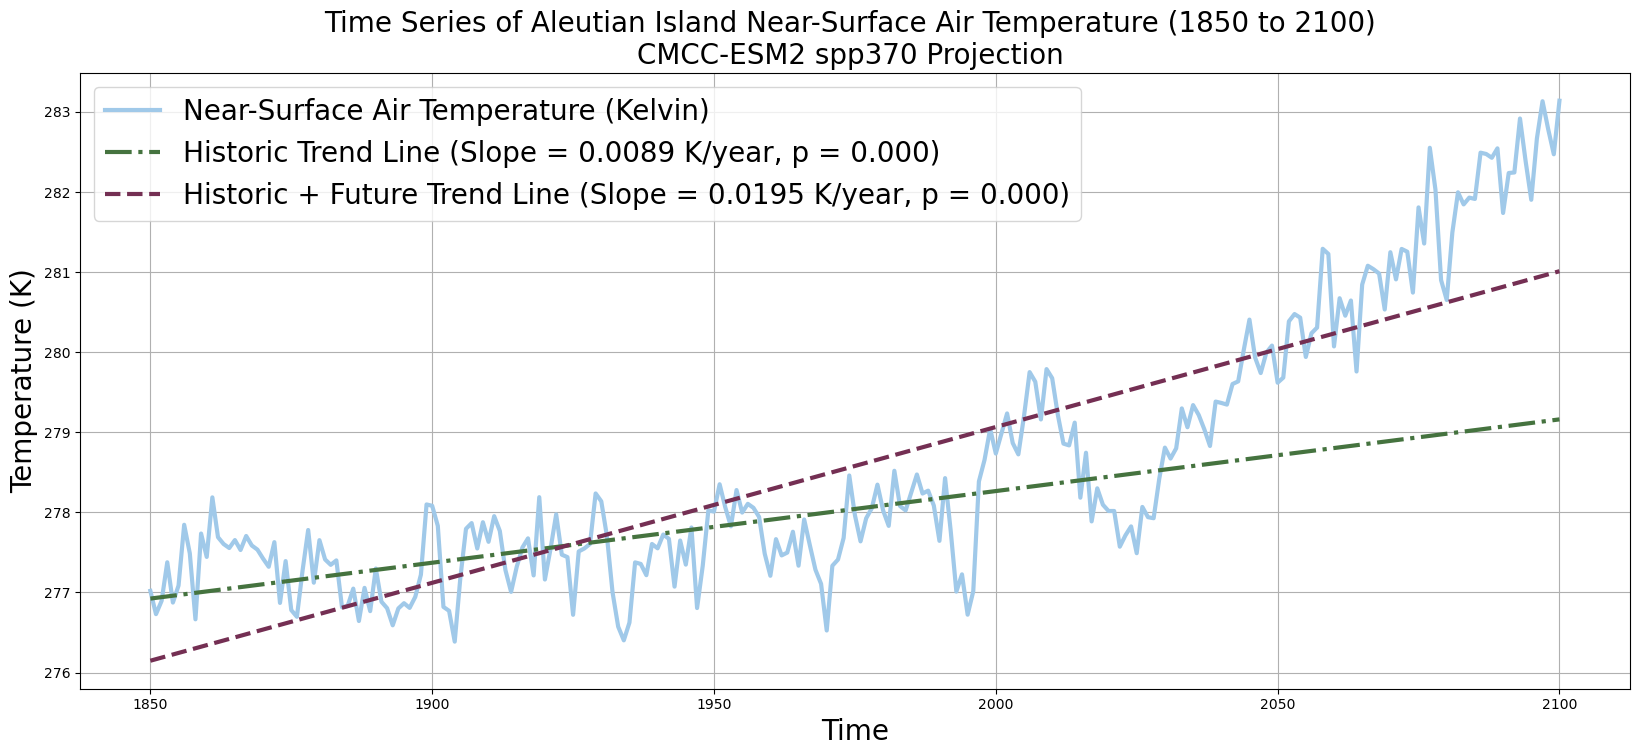

In [19]:
# cmcc370 time series
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(annual_mean_cmcc_370.year, annual_mean_cmcc_370, 
        label='Near-Surface Air Temperature (Kelvin)', 
        color='#A0C9E9', lw=3)

# trend - historic
ax.plot(annual_mean_cmcc_370.year, trend_line_cmcc_hist(annual_mean_cmcc_370.year), 
        color='#45733F', linestyle='-.', lw=3, 
        label=f'Historic Trend Line (Slope = {x_cmcc_hist[0]:.4f} K/year, p = {p_val_cmcc_hist:.3f})')

# trend - historic + projection
ax.plot(annual_mean_cmcc_370.year, trend_line_cmcc_370(annual_mean_cmcc_370.year), 
        color='#742F53', linestyle='--', lw=3, 
        label=f'Historic + Future Trend Line (Slope = {x_cmcc_370[0]:.4f} K/year, p = {p_val_cmcc_370:.3f})')

# labels
ax.set_title("Time Series of Aleutian Island Near-Surface Air Temperature (1850 to 2100) \nCMCC-ESM2 spp370 Projection ", fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Temperature (K)", fontsize=20)
ax.legend(fontsize=20)
ax.grid()
plt.show()

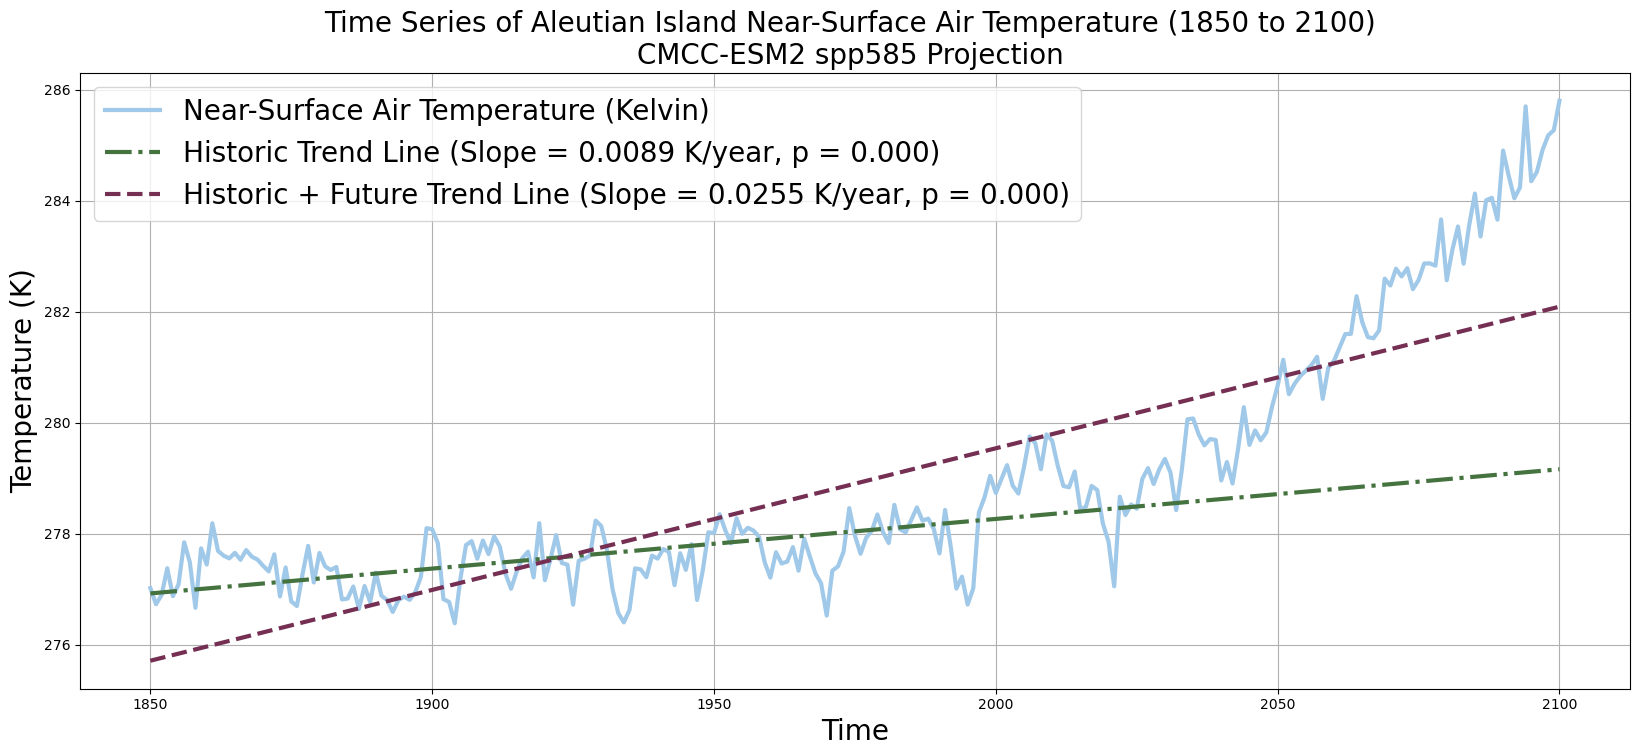

In [20]:
# cmcc585 time series
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(annual_mean_cmcc_585.year, annual_mean_cmcc_585, 
        label='Near-Surface Air Temperature (Kelvin)', lw=3, color='#A0C9E9')

# trend - historic
ax.plot(annual_mean_cmcc_585.year, trend_line_cmcc_hist(annual_mean_cmcc_585.year), 
        color='#45733F', linestyle='-.', lw=3, 
        label=f'Historic Trend Line (Slope = {x_cmcc_hist[0]:.4f} K/year, p = {p_val_cmcc_hist:.3f})')

# trend - historic + projection
ax.plot(annual_mean_cmcc_585.year, trend_line_cmcc_585(annual_mean_cmcc_585.year), 
        color='#742F53', linestyle='--', lw=3, 
        label=f'Historic + Future Trend Line (Slope = {x_cmcc_585[0]:.4f} K/year, p = {p_val_cmcc_585:.3f})')

# labels
ax.set_title("Time Series of Aleutian Island Near-Surface Air Temperature (1850 to 2100) \nCMCC-ESM2 spp585 Projection ", fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Temperature (K)", fontsize=20)
ax.legend(fontsize=20)
ax.grid()
plt.show()

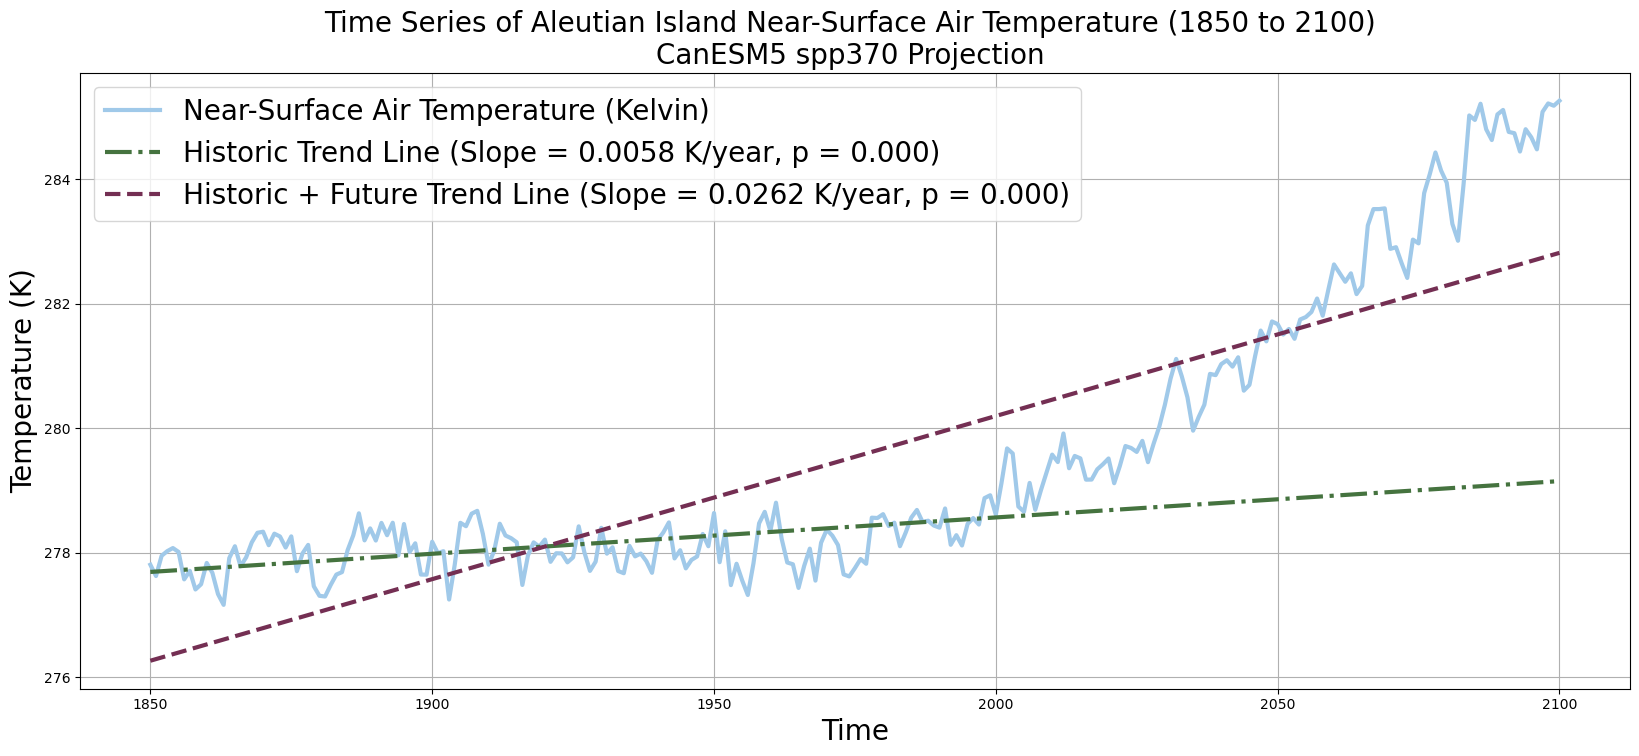

In [21]:
# can370 time series
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(annual_mean_can_370.year, annual_mean_can_370, 
        label='Near-Surface Air Temperature (Kelvin)', lw=3, color='#A0C9E9')

# trend - historic
ax.plot(annual_mean_can_370.year, trend_line_can_hist(annual_mean_can_370.year), 
        color='#45733F', linestyle='-.', lw=3, 
        label=f'Historic Trend Line (Slope = {x_can_hist[0]:.4f} K/year, p = {p_val_can_hist:.3f})')

# trend - historic + projection
ax.plot(annual_mean_can_370.year, trend_line_can_370(annual_mean_can_370.year), 
        color='#742F53', linestyle='--', lw=3, 
        label=f'Historic + Future Trend Line (Slope = {x_can_370[0]:.4f} K/year, p = {p_val_can_370:.3f})')

# labels
ax.set_title("Time Series of Aleutian Island Near-Surface Air Temperature (1850 to 2100) \nCanESM5 spp370 Projection ", fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Temperature (K)", fontsize=20)
ax.legend(fontsize=20)
ax.grid()
plt.show()

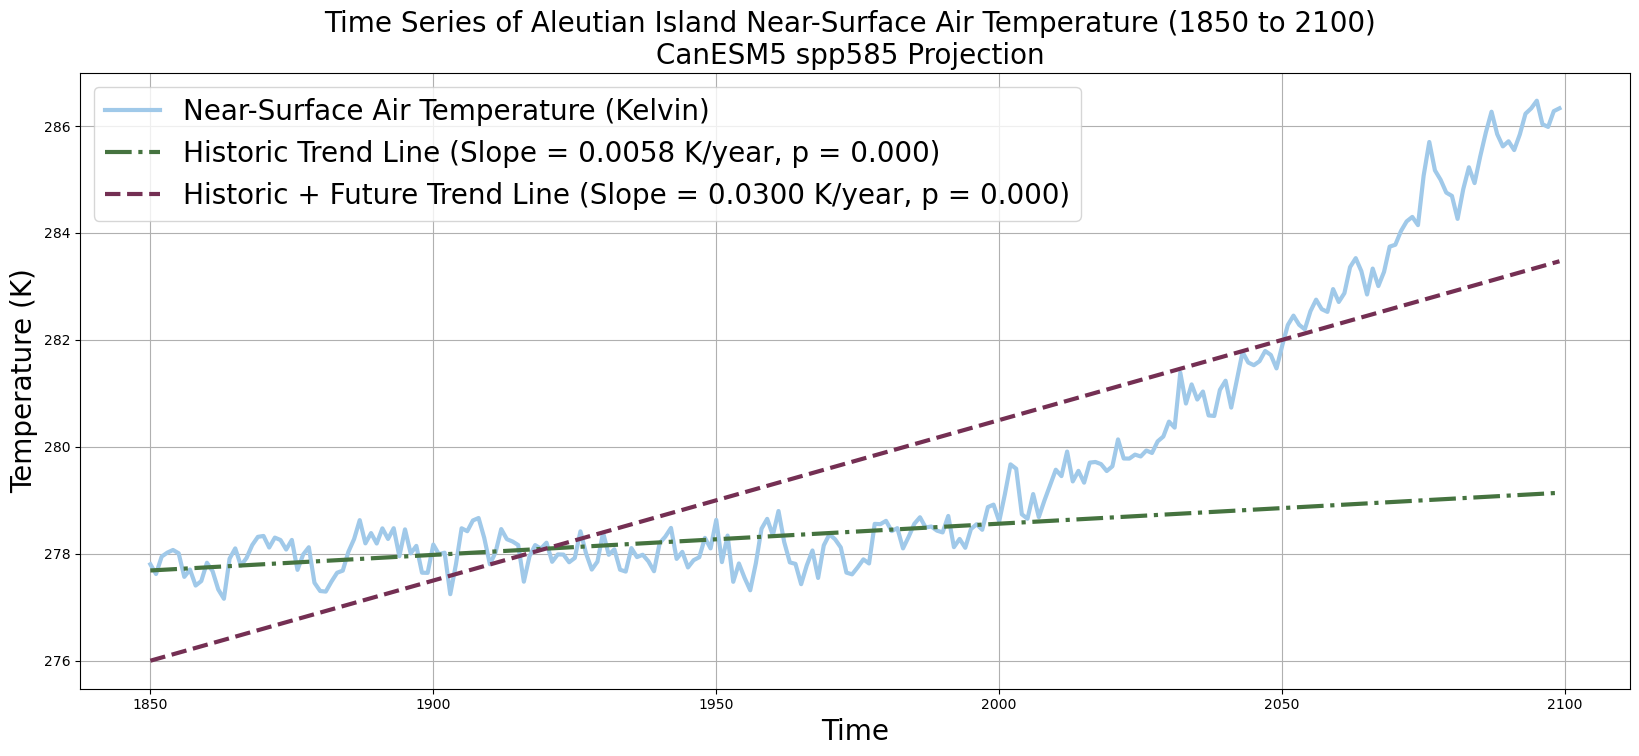

In [22]:
# can585 time series
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(annual_mean_can_585.year, annual_mean_can_585, 
        label='Near-Surface Air Temperature (Kelvin)', lw=3, color='#A0C9E9')

# trend - historic
ax.plot(annual_mean_can_585.year, trend_line_can_hist(annual_mean_can_585.year), 
        color='#45733F', linestyle='-.', lw=3, 
        label=f'Historic Trend Line (Slope = {x_can_hist[0]:.4f} K/year, p = {p_val_can_hist:.3f})')

# trend - historic + projection
ax.plot(annual_mean_can_585.year, trend_line_can_585(annual_mean_can_585.year), 
        color='#742F53', linestyle='--', lw=3, 
        label=f'Historic + Future Trend Line (Slope = {x_can_585[0]:.4f} K/year, p = {p_val_can_585:.3f})')

# labels
ax.set_title("Time Series of Aleutian Island Near-Surface Air Temperature (1850 to 2100) \nCanESM5 spp585 Projection ", fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Temperature (K)", fontsize=20)
ax.legend(fontsize=20)
ax.grid()
plt.show()

Above, I have plotted area-weighted, annually averaged time series from two climate models with two projection scenarios each.

In all historic and future-projected scenarios, we see positive slopes indicating an increase in near-surface air temperature. All of these changes in temperatures within each scenario are statistically significant with extremely low p-values. For both models, the future-projected trends show much steeper increase in temperature over time than the historic trends.

All of these plots show quite similar trends of increasing temperatures to roughly the same degree. Increasing temperatures in this region are bound to have major impacts on Aleutian ecosystems and the people that rely on them. In these rural coastal communities, people depend on resilient fisheries for commercial, recreational and subsistence needs. Warming effects have shifted fish and marine mammal populations, increased the risk of algal toxins, and driven ocean acidification. As temperatures continue to rise, Aleutian people will continue to integrate local community knowledge with research to build resilience and adaptation strategies.